# 모델성능평가

## 혼동 행렬

`caret::confusionMatrix`: 혼동 행렬과 관련된 메트릭을 계산한다

In [15]:
predicted <- c(1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1)
actual <- c(1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1)
xtabs(~ predicted + actual)

accuracy를 직접 구해보면 다음과 같다

In [2]:
sum(predicted == actual) / NROW(actual)

[1] 0.75

In [17]:
library(caret)
confusionMatrix(as.factor(predicted), as.factor(actual))

Confusion Matrix and Statistics

          Reference
Prediction 0 1
         0 3 2
         1 1 6
                                          
               Accuracy : 0.75            
                 95% CI : (0.4281, 0.9451)
    No Information Rate : 0.6667          
    P-Value [Acc > NIR] : 0.3931          
                                          
                  Kappa : 0.4706          
                                          
 Mcnemar's Test P-Value : 1.0000          
                                          
            Sensitivity : 0.7500          
            Specificity : 0.7500          
         Pos Pred Value : 0.6000          
         Neg Pred Value : 0.8571          
             Prevalence : 0.3333          
         Detection Rate : 0.2500          
   Detection Prevalence : 0.4167          
      Balanced Accuracy : 0.7500          
                                          
       'Positive' Class : 0               
                                          

## ROC 커브

`POCR::prediction`: prediction 객체를 생성한다<br>
`POCR::performance`: prediction 객체로부터 performance 객체를 생성한다

In [22]:
set.seed(137)
probs <- runif(100)
labels <- as.factor(ifelse(probs >.5 & runif(100) < .4, "A", "B"))

In [40]:
library(ROCR)

In [41]:
pred <- prediction(probs, labels)
pred

A prediction instance
  with 100 data points

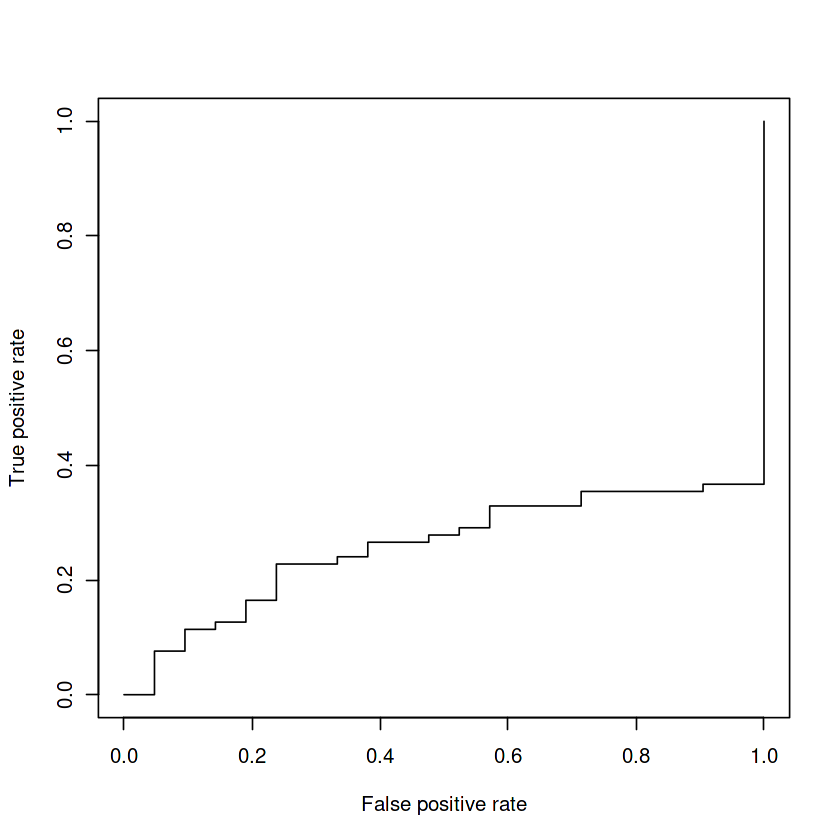

In [25]:
plot(performance(pred, 'tpr', 'fpr'))

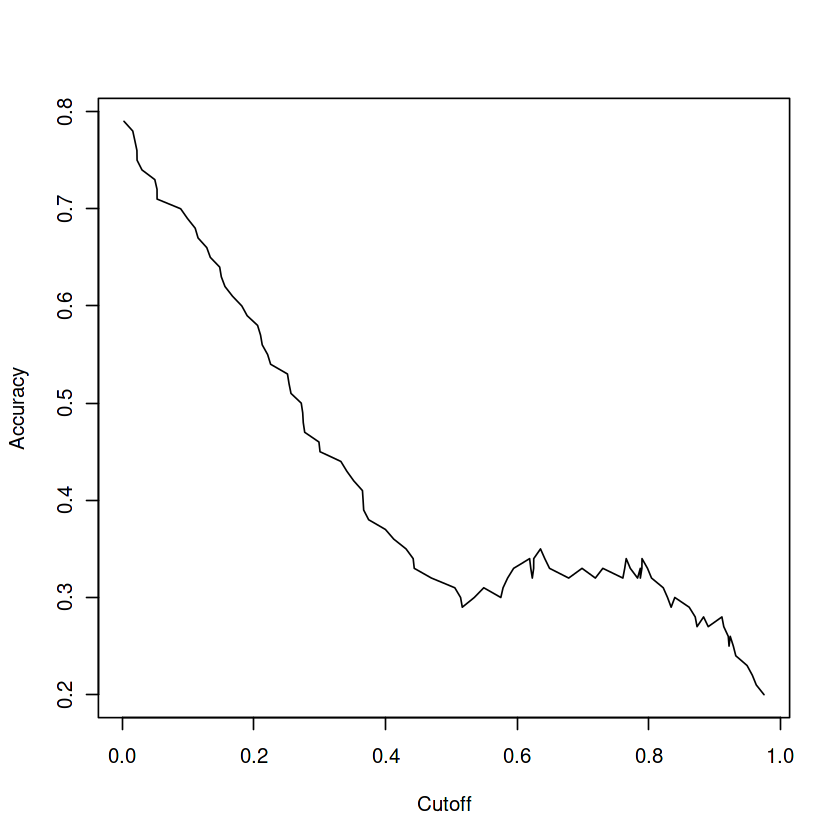

In [26]:
plot(performance(pred, 'acc', 'cutoff'))

In [42]:
performance(pred, measure="auc")

A performance instance
  'Area under the ROC curve'

## 교차 검증

`cvTools::cvFolds`: n개의 관찰을 K 교차 검증의 R회 반복으로 분할한다

In [44]:
library(cvTools)

10개의 데이터를 K=5, R=1,임의 방식으로 실행해보자.

Fold가 1일 때, Index는 4, 3 이므로 교차 검증에서 K=1일 때, 4번, 3번 데이터를 검증 데이터로 사용하고 나머지를 훈련데이터로 사용하면 된다.

In [45]:
cvFolds(10, K=5, type="random")


5-fold CV:    
Fold   Index
   1       4
   2       9
   3       2
   4       6
   5       7
   1       3
   2       5
   3       1
   4      10
   5       8

consecutive (연속): 연속된 데이터를 차례로 검증 데이터로 사용한다

In [46]:
cvFolds(10, K=5, type="consecutive")


5-fold CV:    
Fold   Index
   1       1
   1       2
   2       3
   2       4
   3       5
   3       6
   4       7
   4       8
   5       9
   5      10

interleaved (상호배치): 연속된 데이터를 차례로 서로 다른 K의 검증 데이터로 할당한다

In [47]:
cvFolds(10, K=5, type="interleaved")


5-fold CV:    
Fold   Index
   1       1
   2       2
   3       3
   4       4
   5       5
   1       6
   2       7
   3       8
   4       9
   5      10

Fold에 해당하는 부분은 `cv$which`에, 실제 선택할 행을 저장한 부분은 `cv$subset`에 저장되어 있다

In [62]:
set.seed(719)
cv <- cvFolds(NROW(iris),K=10, R=3)

첫 번째 반복의 K = 1 에서 검증 데이터로 사용해야 할 행의 번호는 다음과 같다

In [58]:
validation_idx <- cv$subset[which(cv$which == 1), 1]
validation_idx

[1]  85  15  37   7 114 111  27  72 146 142  50  74 129 106  76

첫 번째 반복 R = 1의 K = 1에서 훈련 데이터와 검증 데이터는 다음과 같다

In [61]:
train <- iris[-validation_idx, ]
validation <- iris[validation_idx, ]

**K 교차 검증을 반복하는 전체 코드**

`foreach`는 값을 반환할 수 있어 모델 평가 결과를 한 번에 모을 수 있다. 또한, `.combine=c`로 지정하여 결과가 리스트가 아닌 벡터가 되도록 하여 리스트의 리스트가 아닌 벡터의 리스트가 되도록 하였다.

In [64]:
library(foreach)
set.seed(719)
R <- 3
K <- 10

cv <- cvFolds(NROW(iris), K=K, R=R)
foreach(r=1:R) %do% {
    foreach(k=1:K, .combine=c) %do% {
        validation_idx <- cv$subsets[which(cv$which == k), r]
        train <- iris[-validation_idx, ]
        validation <- iris[validation_idx, ]
        
        # 데이터 전처리
        # 모델 훈련
        # 예측
        # 성능 평가
        # return(성능값) -> 반환값으로부터 성능이 가장 뛰어난 모델링 방법 식별
    }
}

[[1]]
[[1]]$Sepal.Length
 [1] 5.4 5.8 5.5 4.6 5.7 6.5 5.0 6.1 6.7 6.9 5.0 6.1 6.4 7.6 6.6

[[1]]$Sepal.Width
 [1] 3.0 4.0 3.5 3.4 2.5 3.2 3.4 2.8 3.0 3.1 3.3 2.8 2.8 3.0 3.0

[[1]]$Petal.Length
 [1] 4.5 1.2 1.3 1.4 5.0 5.1 1.6 4.0 5.2 5.1 1.4 4.7 5.6 6.6 4.4

[[1]]$Petal.Width
 [1] 1.5 0.2 0.2 0.3 2.0 2.0 0.4 1.3 2.3 2.3 0.2 1.2 2.1 2.1 1.4

[[1]]$Species
 [1] versicolor setosa     setosa     setosa     virginica  virginica 
 [7] setosa     versicolor virginica  virginica  setosa     versicolor
[13] virginica  virginica  versicolor
Levels: setosa versicolor virginica

[[1]]$Sepal.Length
 [1] 5.9 6.0 6.2 4.6 6.3 5.0 5.4 6.0 7.7 6.3 5.1 6.2 6.7 4.4 6.4

[[1]]$Sepal.Width
 [1] 3.2 3.4 3.4 3.6 3.4 3.4 3.9 3.0 2.8 2.8 3.8 2.9 3.3 3.0 2.9

[[1]]$Petal.Length
 [1] 4.8 4.5 5.4 1.0 5.6 1.5 1.7 4.8 6.7 5.1 1.6 4.3 5.7 1.3 4.3

[[1]]$Petal.Width
 [1] 1.8 1.6 2.3 0.2 2.4 0.2 0.4 1.8 2.0 1.5 0.2 1.3 2.1 0.2 1.3

[[1]]$Species
 [1] versicolor versicolor virginica  setosa     virginica  setosa    
 [7] setosa     virginica  virginica  virginica  setosa     versicolor
[13] virginica  setosa     versicolor
Levels: setosa versicolor virginica

[[1]]$Sepal.Length
 [1] 5.7 6.1 5.0 6.3 7.7 5.1 7.2 5.0 6.2 5.0 5.8 5.9 4.8 6.0 6.5

[[1]]$Sepal.Width
 [1] 2.6 3.0 3.5 2.5 3.8 3.5 3.0 3.0 2.2 2.3 2.6 3.0 3.4 2.2 3.0

[[1]]$Petal.Length
 [1] 3.5 4.6 1.6 4.9 6.7 1.4 5.8 1.6 4.5 3.3 4.0 5.1 1.6 4.0 5.8

[[1]]$Petal.Width
 [1] 1.0 1.4 0.6 1.5 2.2 0.2 1.6 0.2 1.5 1.0 1.2 1.8 0.2 1.0 2.2

[[1]]$Species
 [1] versicolor versicolor setosa     versicolor virginica  setosa    
 [7] virginica  setosa     versicolor versicolor versicolor virginica 
[13] setosa     versicolor virginica 
Levels: setosa versicolor virginica

[[1]]$Sepal.Length
 [1] 7.2 6.8 5.5 6.5 6.9 6.2 6.3 7.1 5.0 5.2 6.7 5.8 5.0 4.4 5.7

[[1]]$Sepal.Width
 [1] 3.2 3.0 2.4 3.0 3.1 2.8 2.3 3.0 3.5 2.7 3.1 2.7 3.6 3.2 3.0

[[1]]$Petal.Length
 [1] 6.0 5.5 3.7 5.5 4.9 4.8 4.4 5.9 1.3 3.9 4.4 5.1 1.4 1.3 4.2

[[1]]$Petal.Width
 [1] 1.8 2.1 1.0 1.8 1.5 1.8 1.3 2.1 0.3 1.4 1.4 1.9 0.2 0.2 1.2

[[1]]$Species
 [1] virginica  virginica  versicolor virginica  versicolor virginica 
 [7] versicolor virginica  setosa     versicolor versicolor virginica 
[13] setosa     setosa     versicolor
Levels: setosa versicolor virginica

[[1]]$Sepal.Length
 [1] 5.4 5.5 4.7 5.6 6.4 6.7 5.4 6.4 7.4 6.8 4.9 5.8 4.4 6.6 5.2

[[1]]$Sepal.Width
 [1] 3.7 2.5 3.2 2.9 2.8 3.1 3.4 3.2 2.8 2.8 3.0 2.7 2.9 2.9 4.1

[[1]]$Petal.Length
 [1] 1.5 4.0 1.3 3.6 5.6 5.6 1.7 4.5 6.1 4.8 1.4 5.1 1.4 4.6 1.5

[[1]]$Petal.Width
 [1] 0.2 1.3 0.2 1.3 2.2 2.4 0.2 1.5 1.9 1.4 0.2 1.9 0.2 1.3 0.1

[[1]]$Species
 [1] setosa     versicolor setosa     versicolor virginica  virginica 
 [7] setosa     versicolor virginica  versicolor setosa     virginica 
[13] setosa     versicolor setosa    
Levels: setosa versicolor virginica

[[1]]$Sepal.Length
 [1] 6.1 5.1 6.7 5.5 5.1 6.4 5.2 5.6 6.9 5.1 4.8 6.4 6.5 6.7 5.4

[[1]]$Sepal.Width
 [1] 2.6 3.8 3.3 2.6 2.5 3.2 3.4 3.0 3.1 3.7 3.4 3.1 3.0 3.1 3.4

[[1]]$Petal.Length
 [1] 5.6 1.9 5.7 4.4 3.0 5.3 1.4 4.5 5.4 1.5 1.9 5.5 5.2 4.7 1.5

[[1]]$Petal.Width
 [1] 1.4 0.4 2.5 1.2 1.1 2.3 0.2 1.5 2.1 0.4 0.2 1.8 2.0 1.5 0.4

[[1]]$Species
 [1] virginica  setosa     virginica  versicolor versicolor virginica 
 [7] setosa     versicolor virginica  setosa     setosa     virginica 
[13] virginica  versicolor setosa    
Levels: setosa versicolor virginica

[[1]]$Sepal.Length
 [1] 5.7 4.9 5.1 6.0 4.8 5.9 4.7 4.3 4.9 7.2 5.5 5.1 4.9 6.3 5.7

[[1]]$Sepal.Width
 [1] 4.4 3.6 3.5 2.2 3.0 3.0 3.2 3.0 2.4 3.6 2.3 3.8 3.1 2.7 2.8

[[1]]$Petal.Length
 [1] 1.5 1.4 1.4 5.0 1.4 4.2 1.6 1.1 3.3 6.1 4.0 1.5 1.5 4.9 4.1

[[1]]$Petal.Width
 [1] 0.4 0.1 0.3 1.5 0.1 1.5 0.2 0.1 1.0 2.5 1.3 0.3 0.2 1.8 1.3

[[1]]$Species
 [1] setosa     setosa     setosa     virginica  setosa     versicolor
 [7] setosa     setosa     versicolor virginica  versicolor setosa    
[13] setosa     virginica  versicolor
Levels: setosa versicolor virginica

[[1]]$Sepal

**Y값을 고려한 훈련 데이터와 테스트 데이터의 분리**

`caret::createDataPartition`: 데이터를 훈련 데이터와 테스트 데이터로 분리<br>
`caret::createFolds`: 데이터를 K 교차 검증으로 분할<br>
`caret::createMultiFolds`: 데이터를 K 교차 검증의 times 반복으로 분할

아이리스 데이터의 80%를 훈련 데이터, 20%를 검증 데이터로 분리해보자.<br>
Species를 고려하여 데이터를 분리하게 된다.

In [66]:
parts <- createDataPartition(iris$Species, p=0.8)
parts

$Resample1
  [1]   1   2   3   4   5   6   7   8   9  10  11  13  15  18  19  21  22  23
 [19]  25  26  27  28  29  30  32  33  34  35  37  38  40  41  43  44  45  46
 [37]  47  48  49  50  51  52  53  55  56  57  58  59  60  62  63  64  65  67
 [55]  68  70  71  73  74  75  76  77  78  79  81  83  84  85  86  87  89  90
 [73]  91  93  94  95  96  97  99 100 101 104 105 106 107 108 109 110 111 112
 [91] 113 114 115 117 118 120 121 122 123 124 125 126 127 129 130 132 133 134
[109] 137 138 139 140 143 144 145 146 147 148 149 150

In [67]:
table(iris[parts$Resample1, "Species"])


    setosa versicolor  virginica 
        40         40         40 

In [68]:
createFolds(iris$Species, k=10)

$Fold01
 [1]  14  31  39  48  50  59  79  80  87  95 106 122 130 134 136

$Fold02
 [1]   1  10  17  42  43  65  70  77  83  99 103 105 126 137 141

$Fold03
 [1]   9  29  30  38  47  54  58  74  76  93 107 112 138 145 150

$Fold04
 [1]   4   6  12  41  49  51  60  71  81  92 117 120 123 127 148

$Fold05
 [1]   3   8  11  33  37  55  67  85  89  96 104 108 115 118 146

$Fold06
 [1]   5  21  25  27  46  53  57  69  78  91 102 109 121 135 139

$Fold07
 [1]  13  16  23  26  34  64  66  88  94  97 101 129 143 144 149

$Fold08
 [1]   2  28  32  36  45  62  86  90  98 100 116 124 125 132 142

$Fold09
 [1]  18  19  20  40  44  68  72  73  82  84 110 114 131 140 147

$Fold10
 [1]   7  15  22  24  35  52  56  61  63  75 111 113 119 128 133

In [70]:
createMultiFolds(iris$Species, k=10, times=3)

$Fold01.Rep1
  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  15  17  18  20  21
 [19]  22  23  24  26  27  28  29  30  31  32  33  35  36  37  38  39  40  41
 [37]  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
 [55]  60  61  62  63  64  65  66  67  68  69  70  72  73  75  77  78  79  80
 [73]  81  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  99 100
 [91] 101 102 103 104 105 106 108 109 110 111 112 113 114 115 116 118 119 120
[109] 121 122 123 124 126 127 128 129 130 131 132 133 134 136 137 138 140 141
[127] 142 143 144 145 146 147 148 149 150

$Fold02.Rep1
  [1]   1   3   4   5   6   7   8   9  10  12  13  14  15  16  17  18  19  20
 [19]  22  23  24  25  26  27  29  31  32  33  34  35  36  37  38  39  40  41
 [37]  42  43  44  45  46  47  48  49  50  52  53  54  55  56  57  58  59  60
 [55]  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
 [73]  80  82  83  84  86  87  88  89  90  91  92  93  94  95  97  98  99 100
 [91] 101 102 103 104 105 106 107 109 110 111 112 113 114 115 116 117 118 119
[109] 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 138
[127] 139 140 141 143 144 145 146 149 150

$Fold03.Rep1
  [1]   1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  18  19  20
 [19]  21  22  23  24  25  27  28  29  30  31  32  33  34  35  36  37  38  39
 [37]  40  41  42  43  45  46  47  49  50  51  52  54  55  56  57  58  60  61
 [55]  62  63  64  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
 [73]  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  98  99
 [91] 101 103 104 106 107 108 109 110 112 113 114 115 117 118 119 120 121 122
[109] 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
[127] 141 142 143 144 145 147 148 149 150

$Fold04.Rep1
  [1]   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18  19
 [19]  20  21  22  23  24  25  26  27  28  30  31  32  33  34  35  36  39  40
 [37]  41  42  43  44  45  46  47  48  49  51  52  53  56  57  58  59  60  61
 [55]  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78  79  80
 [73]  81  82  83  84  85  87  88  90  91  92  93  94  95  96  97  98  99 100
 [91] 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118 119
[109] 120 121 122 123 124 125 126 128 129 130 133 134 135 136 137 138 139 140
[127] 142 143 144 145 146 147 148 149 150

$Fold05.Rep1
  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19
 [19]  20  21  22  24  25  26  28  29  30  31  32  33  34  36  37  38  40  41
 [37]  42  43  44  45  46  47  48  49  50  51  52  53  54  55  57  58  59  60
 [55]  61  62  63  64  65  66  67  68  70  71  72  73  74  76  77  78  79  80
 [73]  81  82  83  84  85  86  88  89  90  91  92  93  94  96  97  98  99 100
 [91] 101 102 105 106 107 108 109 110 111 112 114 115 116 117 119 120 121 122
[109] 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 141
[127] 142 143 144 145 146 147 148 149 150

$Fold06.Rep1
  [1]   1   2   3   4   6   7   8   9  11  12  13  14  16  17  18  19  20  21
 [19]  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
 [37]  40  42  43  44  45  47  48  49  50  51  52  53  54  55  56  57  59  60
 [55]  61  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  78  81
 [73]  82  83  84  85  86  87  88  89  91  92  93  94  95  96  97  98  99 100
 [91] 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118
[109] 119 120 122 123 125 126 127 128 130 131 132 135 136 137 138 139 140 141
[127] 142 143 144 145 146 147 148 149 150

$Fold07.Rep1
  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38
 [37]  39  41  43  44  45  46  47  48  50  51  52  53  54  55  56  57  58  59
 [55]  60  61  63  64  65  66  67  68  69  71  72  73  74  75  76  77  78  79
 [73]  80  81  82  83  85  86  87  88  89  90  92  93  94  95  

In [ ]:
set.seed(137)
k <- 10
times <- 3

cv <- createMultiFolds(iris$Species, k, times)
for (i in 1:times) {
    for (j in 1:k) {
        train_idx <- cv[[i * times + k]]
        iris_train <- iris[train_idx, ]
        iris_validation <- iris[-train_idx, ]
        # 데이터 전처리
        # 모델 훈련
        # 예측
        # 성능 평가
    }
}